# Reproducing [Interpreting Context Look-ups in Transformers: Investigating Attention-MLP Interactions](https://arxiv.org/abs/2402.15055)
- This notebook aims to reproduce `Section 4: Methodology` from Neo et al. 2024

In [49]:
print("Init Reproducing Neo et al. 2024")

Init Reproducing Neo et al. 2024


In [50]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

In [51]:
def get_device():
    if torch.cuda.is_available():
        print("Using CUDA GPU")
        return torch.device("cuda")
    else:
        print("Using CPU")
        return torch.device("cpu")
device = get_device()

Using CPU


## 0: Load Model

In [52]:
tokenizer = AutoTokenizer.from_pretrained(
    "openai-community/gpt2",
    output_hidden_states=True,
    output_attentions=True
)
model = AutoModelForCausalLM.from_pretrained("openai-community/gpt2")

In [53]:
print("Sanity Check that model is loaded: ")
tokenized_sample_input = tokenizer("one two three", return_tensors="pt")

with torch.no_grad():
    model_output = model(**tokenized_sample_input)

next_token_id = model_output.logits[:, -1, :].argmax(dim=-1)

print("Tokenization shape", tokenized_sample_input.input_ids.shape)
print("Model Output shape", model_output.logits.shape)

print("Predicted next token:", tokenizer.decode(next_token_id))

Sanity Check that model is loaded: 
Tokenization shape torch.Size([1, 3])
Model Output shape torch.Size([1, 3, 50257])
Predicted next token:  four


## Model Architecture Analysis

### Model Hyperparameters
- Vocab Size = 50257
- Max Context Length = 1024
- d_model = 768
- n_layers = 12 (0-11)
- d_up = 3072


Note: Conv1D(out, in) = nn.Linear(in, out) [historical GPT2 Reasons]
- Thus, `c_fc` is the up projection and `c_proj` is the down projection
- 2304 / 3 = 768 => QKV projections from residual stream in d_model, with MHA for QKV 

```
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768) 
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)
```

In [ ]:
N_LAYERS = len(model.transformer.h)
V = model.lm_head.weight.shape[0] # LM Head is shape [V, d_model]

50257


In [54]:
print("Sanity check model architecture")
model

Sanity check model architecture


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

## 4.1 Identifying Neurons
To compute the similarity of each W_down column to the token embedding vector e^(t):

We will use the following matrices
```
(c_proj): Conv1D(nf=768, nx=3072) --> linear(out=768, in=3072)
(lm_head): Linear(in_features=768, out_features=50257, bias=False)
```

### First Principles: Finding similarity of Layer 0 token to all unembedding vectors

In [ ]:
W_down_layer0_example = model.transformer.h[0].mlp.c_proj.weight.detach() # Layer 0's down projection matrix

print(f"Down projection for layer 0 of shape (d_up, d_model) {W_down_layer0_example.shape} = \n", W_down_layer0_example)

Down projection for layer 0 of shape (d_up, d_model) torch.Size([3072, 768]) = 
 tensor([[-0.1066,  0.1528,  0.0331,  ...,  0.1644, -0.0400,  0.1218],
        [ 0.0364, -0.0594,  0.0848,  ...,  0.0933, -0.0980, -0.0388],
        [-0.0767,  0.0084, -0.0947,  ...,  0.0501, -0.0030, -0.0323],
        ...,
        [-0.1027,  0.0077, -0.0305,  ...,  0.0122,  0.0011, -0.0187],
        [-0.0305, -0.0333, -0.0078,  ...,  0.0902, -0.0444,  0.0043],
        [-0.0221,  0.0818,  0.0775,  ..., -0.0563, -0.0089, -0.0802]])


In [56]:
W_unembedding_example = model.lm_head.weight.detach()

print(f"Unembedding matrix of shape (V, d_model) {W_unembedding_example.shape} = \n", W_unembedding_example)

Unembedding matrix of shape (V, d_model) torch.Size([50257, 768]) = 
 tensor([[-0.1101, -0.0393,  0.0331,  ..., -0.1364,  0.0151,  0.0453],
        [ 0.0403, -0.0486,  0.0462,  ...,  0.0861,  0.0025,  0.0432],
        [-0.1275,  0.0479,  0.1841,  ...,  0.0899, -0.1297, -0.0879],
        ...,
        [-0.0445, -0.0548,  0.0123,  ...,  0.1044,  0.0978, -0.0695],
        [ 0.1860,  0.0167,  0.0461,  ..., -0.0963,  0.0785, -0.0225],
        [ 0.0514, -0.0277,  0.0499,  ...,  0.0070,  0.1552,  0.1207]])


In [ ]:
congruence_layer0_example = W_down_layer0_example @ W_unembedding_example.T

print(f"Congruence Score for layer 0 for all tokens of shape (d_up, V) {congruence_layer0_example.shape} ")

Congruence Score for layer 0 for all tokens of shape (d_up, V) torch.Size([3072, 50257]) 


### Extract Congruence Score for each neuron, token, layer

In [ ]:
# Find the layer l and neuron i for each congruence 
best_congruence = torch.full((V,), fill_value=-torch.inf)
best_congruence_layer = torch.full((V,), fill_value=-1, dtype=torch.long)
best_congruence_neuron = torch.full((V,), fill_value=-1, dtype=torch.long)

for l in range(N_LAYERS):
    W_unembedding = model.lm_head.weight.detach()
    W_down = model.transformer.h[l].mlp.c_proj.weight.detach() 

    congruence_matrix = W_down @ W_unembedding.T # [d_up, V] 

    layer_best_congruence, layer_best_congruence_neuron = torch.max(congruence_matrix, dim=0)

    better_mask = layer_best_congruence > best_congruence
    
    best_congruence[better_mask] = layer_best_congruence[better_mask]
    best_congruence_layer[better_mask] = l
    best_congruence_neuron[better_mask] = layer_best_congruence_neuron[better_mask]
    
    print("Processed Congruence for layer ", l)

Processed layer  0
Processed layer  1
Processed layer  2
Processed layer  3
Processed layer  4
Processed layer  5
Processed layer  6
Processed layer  7
Processed layer  8
Processed layer  9
Processed layer  10
Processed layer  11


In [94]:
%pip install matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
35999.93s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


  Using cached contourpy-1.3.3-cp312-cp312-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.9-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 35.7 MB/s  0:00:00 eta 0:00:01
Using cached contourpy-1.3.3-cp312-cp312-macosx_11_0_arm64.whl (273 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 36.2 MB/s  0:00:00
Using cached kiwisolver-1.4.9-cp312-cp312-macosx_11_0_arm64.whl (64 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 32.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [matplotlib]7 [matplotlib]
Note: you may need to restart the kernel to use updated packages.


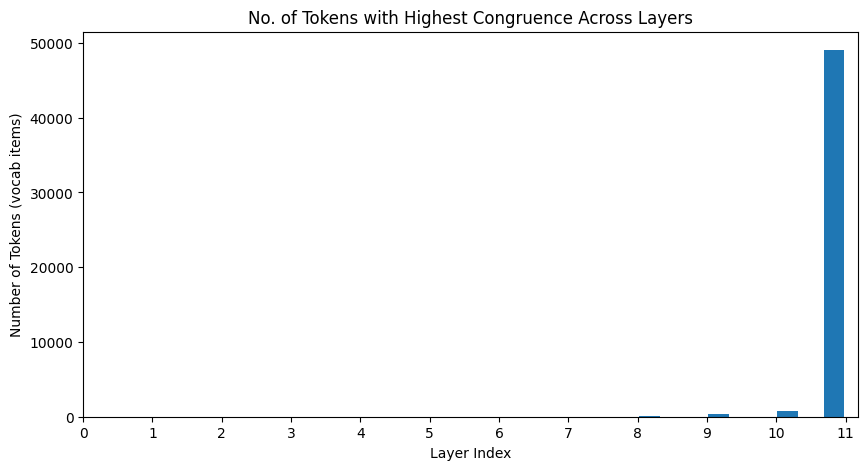

In [98]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(best_congruence_layer.cpu().numpy(), bins=N_LAYERS, rwidth=0.9)

plt.title("No. of Tokens with Highest Congruence Across Layers")
plt.xlabel("Layer Index")
plt.ylabel("Number of Tokens (vocab items)")
plt.xticks(range(N_LAYERS))

plt.show()